# Categorizing LSTM-attention output
load in the generated genre samples. and attempt to categorize it

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
!pip install -q transformers

In [23]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

from transformers import BertTokenizer, TFBertModel
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
# link to data directory
DATA_DIR = "/content/drive/MyDrive/W266 Project/w266-finalproj/data"
CAT_DIR = "/content/drive/MyDrive/W266 Project/w266-finalproj/categorical_model"

DATA_DIR = "/content/drive/MyDrive/w266-finalproj/data"
CAT_DIR = "/content/drive/MyDrive/w266-finalproj/categorical_model"

In [25]:
# data pre-processing

# preprocessing the corpus by converting all letters to lowercase, 
# replacing blank lines with blank string and removing special characters
def preprocessText(text):
  stopChars = [',','(',')','.','-','[',']','"']
  processedText = text.lower()
  for char in stopChars:
      processedText = processedText.replace(char,'')
  return processedText

# Classifying Generated Lyrics

Load lyrics,
Load Model,
Load Tokenizer
Classify both lstm attention and baseline

In [26]:
model_checkpoint = 'bert-base-cased'
npvalid_labels = ['Folk','Jazz','Metal','Pop','R&B','Rap','Rock','Soul']
max_length = 100

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 100)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 100)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 100)]       0           []                               
 er)                                                                                              
                                                                                            

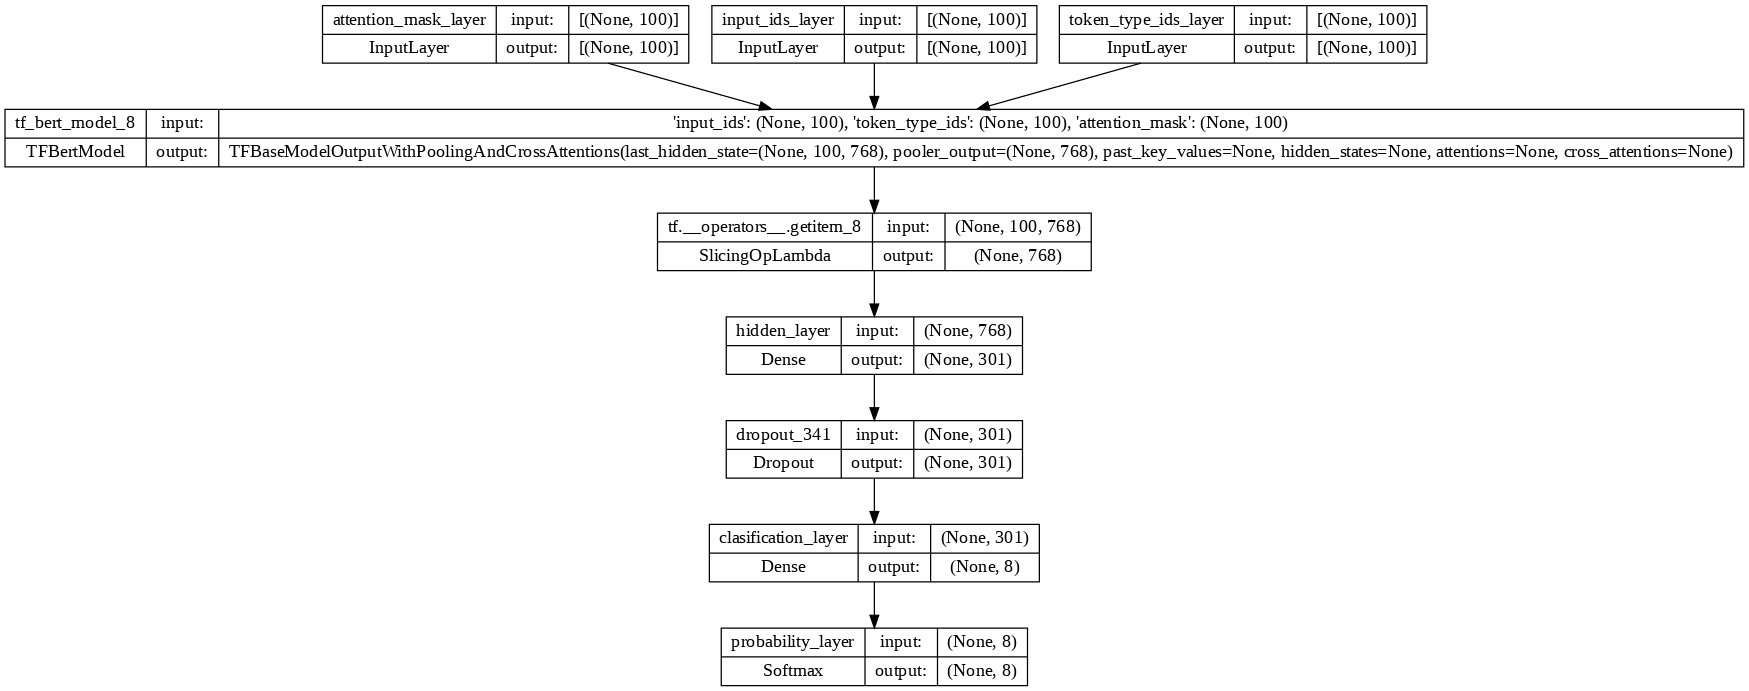

In [27]:

def create_bert_multiclass_model(unique_labels,
                                checkpoint = model_checkpoint,
                                hidden_size = 301, 
                                dropout=0.3,
                                learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooled Output for classification purposes.
    """
    bert_model = TFBertModel.from_pretrained(checkpoint)                                             
    #bert_model.trainable = False
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    bert_out = bert_model(bert_inputs)
    #pooled_token = bert_out[1] 
    cls_token = bert_out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  
    clasification_layer = tf.keras.layers.Dense(8,name='clasification_layer')(hidden)
    probability_layer = tf.keras.layers.Softmax(name='probability_layer')(clasification_layer)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=probability_layer)    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss='sparse_categorical_crossentropy',
                                 metrics=['accuracy'])
    ### END YOUR CODE
    return classification_model

cat_model = create_bert_multiclass_model(npvalid_labels,checkpoint = model_checkpoint)
cat_model.summary()
keras.utils.plot_model(cat_model, show_shapes=True, dpi=90)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


25/25 [==============================] - 6s 188ms/step
Baseline Results (CLS):
Genre: Folk accuracy: 0.45
Genre: Jazz accuracy: 0.38
Genre: Metal accuracy: 0.48
Genre: Pop accuracy: 0.24
Genre: RB accuracy: 0.11
Genre: Rap accuracy: 0.68
Genre: Rock accuracy: 0.29
Genre: Soul accuracy: 0.79


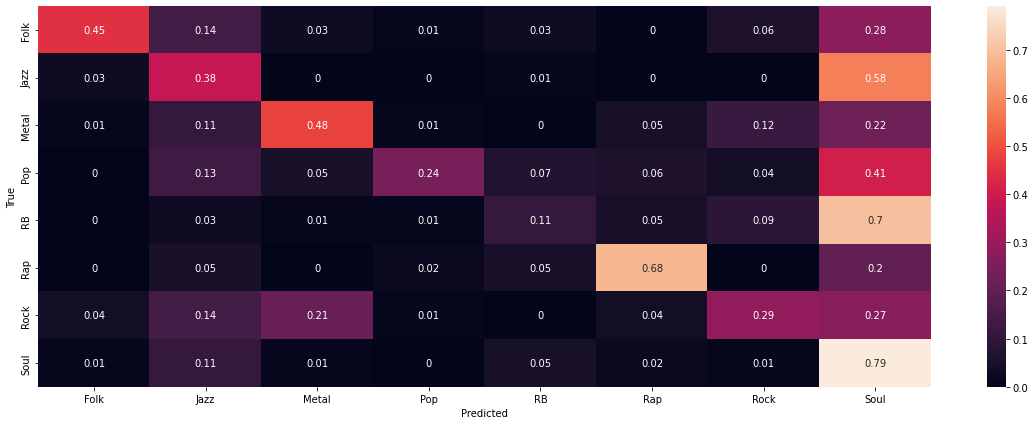

In [28]:
#Model CLS, Data Baseline
model_name = "BERT_CLS_HL301_MW100.h5"

cat_model = create_bert_multiclass_model(npvalid_labels,checkpoint = model_checkpoint)

genres = ['Folk','Jazz','Metal','Pop','RB','Rap','Rock','Soul']
lyrics = [];data_all = []
test_labels = []
i = 0
for genre in genres:
  correct_classifcation = []
  data = pd.read_csv(f"{DATA_DIR}/baseline_{genre.lower()}_generated_lyrics.csv", index_col=0)
  data['generated_lyric'] = data['generated_lyric'].apply(lambda x: preprocessText(x))
  lyrics.append(data['generated_lyric'])
  data_all.append(data)
  test_labels = test_labels + [i for _ in range(len(data))]
  i=i+1
lyrics=pd.concat(lyrics,axis=0)
data_all=pd.concat(data_all,axis=0)

# instantiate pre-trained BERT encoder
# load the classification model
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)

# load in dataset - LSTM baseline
# tokenize it properly, feed into BERT model
max_length=100
  
# tokenize the input
# make the classification
# argmax the prediction to output the actual class
bert_encoded_lyrics =  bert_tokenizer(lyrics.to_list(), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

cat_model.load_weights(f"{CAT_DIR}/{model_name}") 
predictions = cat_model.predict([bert_encoded_lyrics.input_ids, bert_encoded_lyrics.token_type_ids, bert_encoded_lyrics.attention_mask])
predictions = tf.argmax(predictions, axis=-1)

#Confusion map
cm = tf.math.confusion_matrix(test_labels, predictions)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=genres,
    yticklabels=genres)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig(f"{CAT_DIR}/baseline_CLS_CM.png")

genres_lwr = ['folk','jazz','metal','pop','rb','rap','rock','soul']
genres_upr = ['Folk','Jazz','Metal','Pop','R&B','Rap','Rock','Soul']
label_dict = {}
for i,g in enumerate(genres_lwr):
  label_dict[g]=i

data_all['genre_class_act'] = data_all['genre'].map(label_dict)

for i,p in zip(data_all['genre_class_act'].values,predictions):
  if i == p:
    correct_classifcation.append(1)
  else:
    correct_classifcation.append(0) 
#print(f"Genre: {genre} accuracy: {sum(correct_classifcation)/len(correct_classifcation)}")
data_all['genre_class_pred'] = predictions
data_all['correct_classifcation'] = correct_classifcation

data_all.to_csv(f"{CAT_DIR}/baseline_generated_lyrics_classified_CLS.csv", index=False)

print('Baseline Results (CLS):')
for i in range(8):
  genre = genres[i] 
  correct_classifcation_i = correct_classifcation[i*100 : (i*100) + 100]
  print(f"Genre: {genre} accuracy: {sum(correct_classifcation_i)/len(correct_classifcation_i)}")


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


25/25 [==============================] - 9s 186ms/step
LSTM Results (CLS):
Genre: Folk accuracy: 0.43
Genre: Jazz accuracy: 0.45
Genre: Metal accuracy: 0.36
Genre: Pop accuracy: 0.26
Genre: R&B accuracy: 0.1
Genre: Rap accuracy: 0.47
Genre: Rock accuracy: 0.28
Genre: Soul accuracy: 0.87


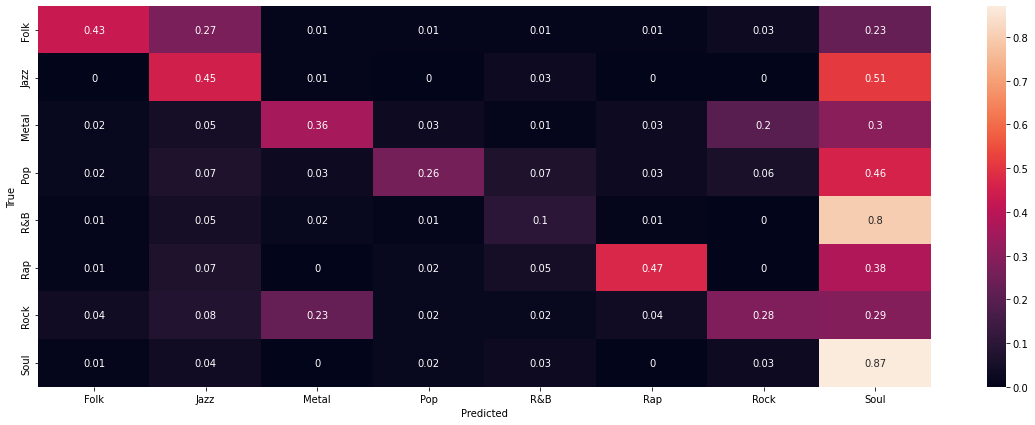

In [29]:
#Model CLS, Data LSTM
#lstm_attention_folk_generated_lyrics_classified
model_name = "BERT_CLS_HL301_MW100.h5"
cat_model = create_bert_multiclass_model(npvalid_labels,checkpoint = model_checkpoint)

genres = ['Folk','Jazz','Metal','Pop','R&B','Rap','Rock','Soul']
lyrics = [];data_all = []
test_labels = []
i = 0
for genre in genres:
  correct_classifcation = []
  data = pd.read_csv(f"{DATA_DIR}/lstm_attention_{genre.lower()}_generated_lyrics.csv", index_col=0)
  data['generated_lyric'] = data[genre].apply(lambda x: preprocessText(x))
  data['genre']=genre
  lyrics.append(data['generated_lyric'])
  data_all.append(data)
  test_labels = test_labels + [i for _ in range(len(data))]
  i=i+1
lyrics=pd.concat(lyrics,axis=0)
data_all=pd.concat(data_all,axis=0)

# instantiate pre-trained BERT encoder
# load the classification model
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)

# load in dataset - LSTM baseline
# tokenize it properly, feed into BERT model
max_length=100
  
# tokenize the input
# make the classification
# argmax the prediction to output the actual class
bert_encoded_lyrics =  bert_tokenizer(lyrics.to_list(), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

cat_model.load_weights(f"{CAT_DIR}/{model_name}") 
predictions = cat_model.predict([bert_encoded_lyrics.input_ids, bert_encoded_lyrics.token_type_ids, bert_encoded_lyrics.attention_mask])
predictions = tf.argmax(predictions, axis=-1)

#Confusion map
cm = tf.math.confusion_matrix(test_labels, predictions)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=genres,
    yticklabels=genres)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig(f"{CAT_DIR}/lstm_attention_CLS_CM.png")

genres_upr = ['Folk','Jazz','Metal','Pop','R&B','Rap','Rock','Soul']
label_dict = {}
for i,g in enumerate(genres_upr):
  label_dict[g]=i

data_all['genre_class_act'] = data_all['genre'].map(label_dict)

for i,p in zip(data_all['genre_class_act'].values,predictions):
  if i == p:
    correct_classifcation.append(1)
  else:
    correct_classifcation.append(0) 
#print(f"Genre: {genre} accuracy: {sum(correct_classifcation)/len(correct_classifcation)}")
data_all['genre_class_pred'] = predictions
data_all['correct_classifcation'] = correct_classifcation

data_all.to_csv(f"{CAT_DIR}/lstm_attention_generated_lyrics_classified_CLS.csv", index=False)

print('LSTM Results (CLS):')
for i in range(8):
  genre = genres[i] 
  correct_classifcation_i = correct_classifcation[i*100 : (i*100) + 100]
  print(f"Genre: {genre} accuracy: {sum(correct_classifcation_i)/len(correct_classifcation_i)}")


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


25/25 [==============================] - 6s 186ms/step
GPT Results (CLS):
Genre: Folk accuracy: 0.26
Genre: Jazz accuracy: 0.51
Genre: Metal accuracy: 0.25
Genre: Pop accuracy: 0.16
Genre: RnB accuracy: 0.0
Genre: Rap accuracy: 0.8
Genre: Rock accuracy: 0.49
Genre: Soul accuracy: 0.36


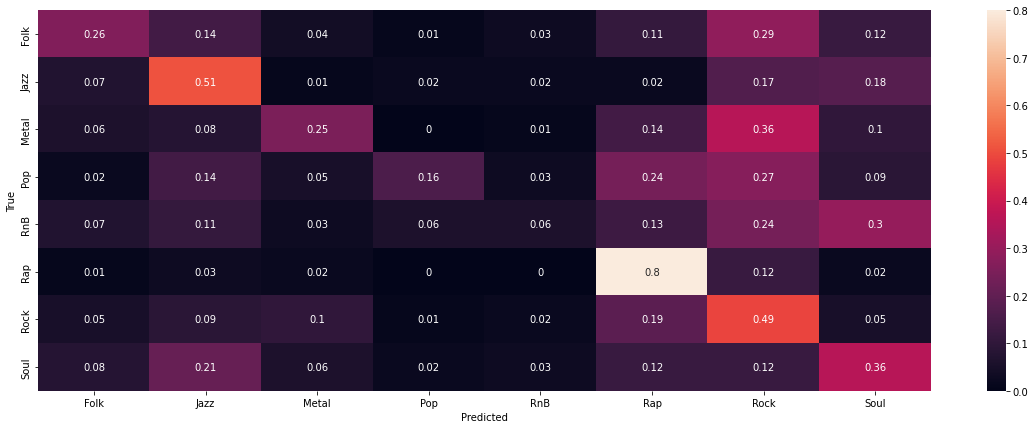

In [30]:
#Model CLS, Data LSTM
#lstm_attention_folk_generated_lyrics_classified
GTP_DATA_DIR = "/content/drive/MyDrive/w266-finalproj/data/gpt-generated-lyrics"
model_name = "BERT_CLS_HL301_MW100.h5"

cat_model = create_bert_multiclass_model(npvalid_labels,checkpoint = model_checkpoint)

genres = ['Folk','Jazz','Metal','Pop','RnB','Rap','Rock','Soul']
lyrics = [];data_all = []
test_labels = []
i = 0
for genre in genres:
  correct_classifcation = []
  data = pd.read_csv(f"{GTP_DATA_DIR}/gpt_{genre.lower()}_generated_lyrics.csv", index_col=0)
  data['generated_lyric'] = data['generated_lyric'].apply(lambda x: preprocessText(x))
  lyrics.append(data['generated_lyric'])
  data_all.append(data)
  test_labels = test_labels + [i for _ in range(len(data))]
  i=i+1
lyrics=pd.concat(lyrics,axis=0)
data_all=pd.concat(data_all,axis=0)

# instantiate pre-trained BERT encoder
# load the classification model
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)

# load in dataset - LSTM baseline
# tokenize it properly, feed into BERT model
max_length=100
  
# tokenize the input
# make the classification
# argmax the prediction to output the actual class
bert_encoded_lyrics =  bert_tokenizer(lyrics.to_list(), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

cat_model.load_weights(f"{CAT_DIR}/{model_name}") 
predictions = cat_model.predict([bert_encoded_lyrics.input_ids, bert_encoded_lyrics.token_type_ids, bert_encoded_lyrics.attention_mask])
predictions = tf.argmax(predictions, axis=-1)

#Confusion map
cm = tf.math.confusion_matrix(test_labels, predictions)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=genres,
    yticklabels=genres)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig(f"{CAT_DIR}/GPT_CLS_CM.png")

genres_upr = ['Folk','Jazz','Metal','Pop','R&B','Rap','Rock','Soul']
label_dict = {}
for i,g in enumerate(genres_upr):
  label_dict[g]=i

data_all['genre_class_act'] = data_all['genre'].map(label_dict)

for i,p in zip(data_all['genre_class_act'].values,predictions):
  if i == p:
    correct_classifcation.append(1)
  else:
    correct_classifcation.append(0) 
#print(f"Genre: {genre} accuracy: {sum(correct_classifcation)/len(correct_classifcation)}")
data_all['genre_class_pred'] = predictions
data_all['correct_classifcation'] = correct_classifcation

data_all.to_csv(f"{CAT_DIR}/GPT_generated_lyrics_classified_CLS.csv", index=False)

print('GPT Results (CLS):')
for i in range(8):
  genre = genres[i] 
  correct_classifcation_i = correct_classifcation[i*100 : (i*100) + 100]
  print(f"Genre: {genre} accuracy: {sum(correct_classifcation_i)/len(correct_classifcation_i)}")
